# Two-Step Techniques (Spy & NB)

This method learns $P(y|x)$ by a two-step technique (step1: Spy, step2: Gaussian NB).

In [1]:
import numpy as np
import pandas as pd

### Load the SCAR dataset

In [2]:
from scar import load_scar

train, valid, test = load_scar()

### Step1: Spy

#### Choose "spy" data from labeled data

In [3]:
train_x, _, train_s = train

np.random.seed(0)

labeled_data_idx = np.where(train_s == 1)[0]
n_spy = round(len(labeled_data_idx) * 0.1)  # 0.1 is the ratio of spy

spy_data_idx = np.random.choice(labeled_data_idx, n_spy, replace=False)
spy = np.zeros_like(train_s)
spy[spy_data_idx] = 1

#### Learn a non-traditional classifier $P(s'|x)$

In [4]:
# s_ (s'): a new label indicator after regarding spy data as unlabeled
train_s_ = train_s & (1 - spy)

In [5]:
from sklearn.linear_model import LogisticRegression

_clf = LogisticRegression(random_state=0).fit(train_x, train_s_)

#### Find $P_{spymin} = \min P(s_|x, spy=1)$

In [6]:
train_s__prob_hat = _clf.predict_proba(train_x)[:, 1]
threshold = train_s__prob_hat[spy.astype(bool)].min()

#### Create a new dataset, regarding data points satisfying $P(s_|x) < P_{spymin}$ as negative

In [7]:
# x_: the dataset consisting of positive-labeled data and negative-labeled data from the dataset x
# y_: the label
data_idx_p = labeled_data_idx
x_p = train_x[data_idx_p]
y_p = np.ones(len(x_p), dtype=np.int32)

data_idx_n = np.where(train_s__prob_hat < threshold)[0]
x_n = train_x[data_idx_n]
y_n = np.zeros(len(x_n), dtype=np.int32)

x_ = np.concatenate([x_n, x_p])
y_ = np.concatenate([y_n, y_p])

### Visualize the newly created dataset

In [8]:
from utils import plot_x_y, plot_x_s

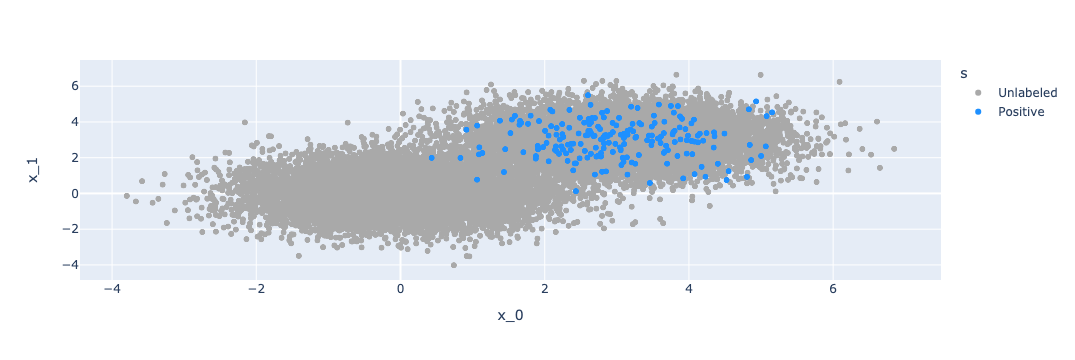

In [10]:
plot_x_s(train_x, spy)

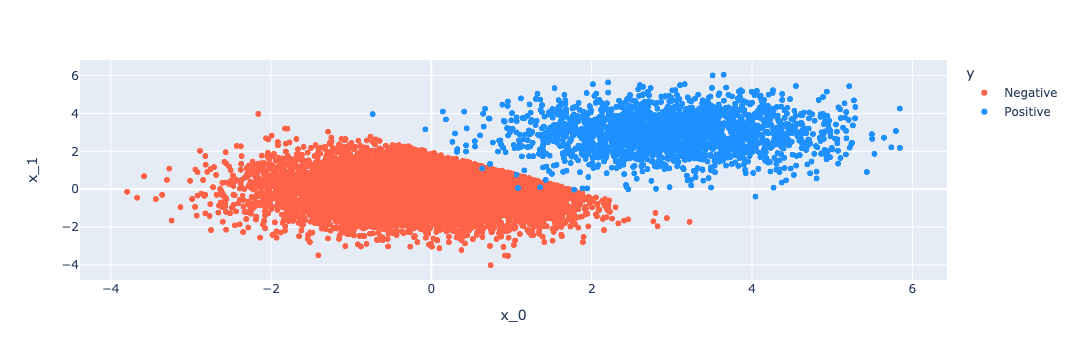

In [11]:
plot_x_y(x_, y_)

### Step2: Learn a Gaussian NB classifier P(y_|x_)
Now, we have positive-labeled data (s=1), negative-labeled data (s=0 & P(s_|x) < P_spymin), and unlabeled data (otherwise).
We learn a classifier only using positive-labeled data and negative-labeled data.

In [12]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB().fit(x_, y_)

### Predict

In [13]:
test_x, test_y, _ = test

test_y_hat = clf.predict(test_x)
test_y_prob_hat = clf.predict_proba(test_x)[:, 1]

### Evaluate the performance

In [14]:
from sklearn.metrics import f1_score

f1_score(test_y, test_y_hat)

0.9829317269076305

### Visualize the result

In [15]:
from utils import plot_x_y_proba

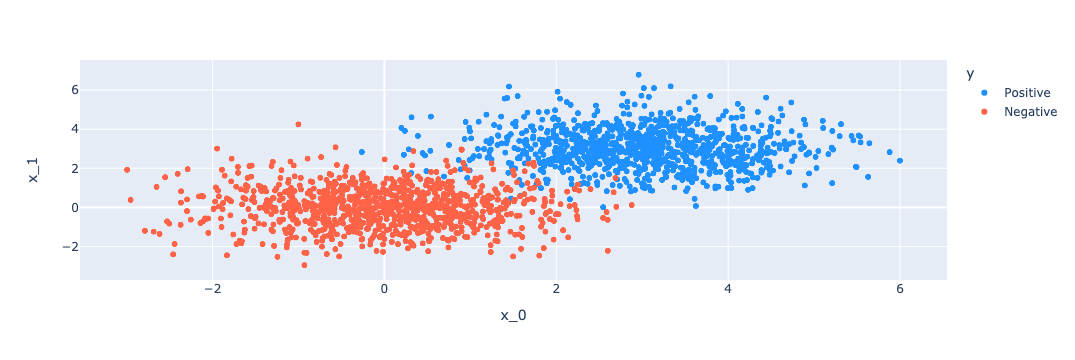

In [16]:
plot_x_y(test_x, test_y)

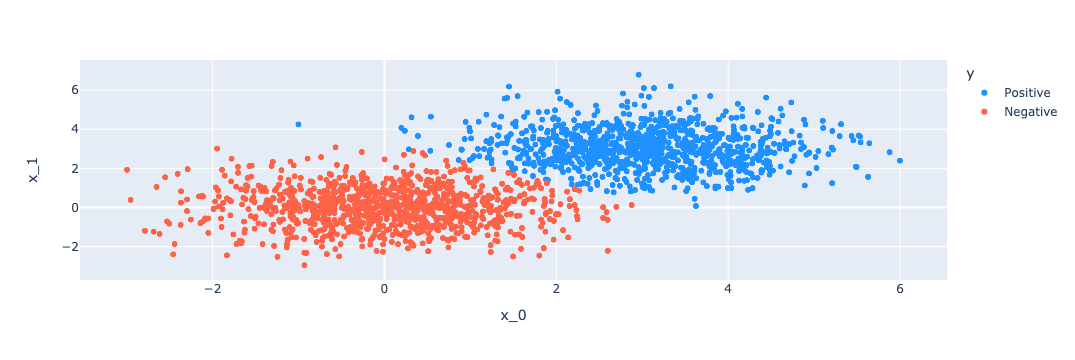

In [17]:
plot_x_y(test_x, test_y_hat)

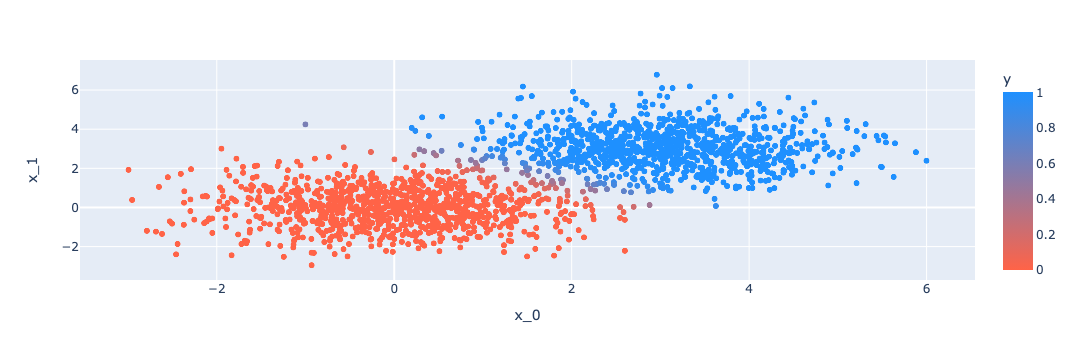

In [18]:
plot_x_y_proba(test_x, test_y_prob_hat)